# LSTM Model for Stock Price Forecasting

This notebook uses an LSTM (Long Short-Term Memory) model to predict the next-day closing price of GOOGL stock using past 5 days of historical data.

## Step 1: Data Collection and Preprocessing

### 1.1 Import Libraries

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


/Users/arvindshine/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### 1.2 Download GOOGL Stock Data

In [18]:
df = yf.download("GOOGL", start="2010-01-01", end="2021-05-31")
df.reset_index(inplace=True)

/var/folders/_p/s_spyhn14rx00tssgxdn92q00000gn/T/ipykernel_35294/2529565348.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("GOOGL", start="2010-01-01", end="2021-05-31")
[*********************100%***********************]  1 of 1 completed


### 1.3 Preprocess the data

To prepare the dataset for training the LSTM model, a few preprocessing steps were applied. First, the 'Open' column was removed since it was not necessary for predicting the closing price. Then, the 'Volume' column was log-transformed to reduce skewness and stabilize fluctuations, after which the original volume column was dropped. Additionally, two new time-related features were created: 'day_of_week', representing the day of the week to help capture weekly trends, and 'day_of_year', which reflects the position of the date within the year to account for any seasonal effects.


In [19]:
# Drop columns 
df.drop(['Open'], axis=1, inplace=True)

# Log transform of volume to reduce skew
df['log_volume'] = np.log(df['Volume'] + 1e-8)
df.drop('Volume', axis=1, inplace=True)

# Add time based features
df['day_of_week'] = df['Date'].dt.dayofweek
df['day_of_year'] = df['Date'].dt.dayofyear

/var/folders/_p/s_spyhn14rx00tssgxdn92q00000gn/T/ipykernel_35294/3909445243.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['Open'], axis=1, inplace=True)
/var/folders/_p/s_spyhn14rx00tssgxdn92q00000gn/T/ipykernel_35294/3909445243.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop('Volume', axis=1, inplace=True)


### 1.4 Feature Engineering: Trend, Volatility, and Momentum Indicators

To enhance the predictive power of the model, several technical indicators were added to capture different market behaviours. A 20-day moving average was calculated to identify trend direction over time. The 20-day rolling standard deviation of the closing price was used to measure market volatility. Additionally, the 14-day Relative Strength Index (RSI) was computed to capture momentum by comparing the average gains and losses over the past 14 days. These indicators help the LSTM model learn patterns related to trend, volatility, and momentum in stock price movements.


In [20]:
# 20 day moving average
df['MA_20'] = df['Close'].rolling(window=20).mean()

# 20 day volatility (Rolling standard deviation)
df['Volatility_20'] = df['Close'].rolling(window=20).std()

# RSI (Relative Strength Index) 14-day
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / (avg_loss + 1e-8)
df['RSI_14'] = 100 - (100 / (1 + rs))


### 1.5 Preparing the Target and Scaling the Features


In [21]:
# Target: next day's close
df['Target'] = df['Close'].shift(-1)

# Scale the target column separately
target_scaler = MinMaxScaler()
df['Target'] = target_scaler.fit_transform(df[['Target']])


# Dropping rows with NaN 
df.dropna(inplace=True)

# Selecting features
features = ['Close', 'High', 'Low', 'log_volume', 'day_of_week', 'day_of_year', 'MA_20', 'Volatility_20', 'RSI_14']

# Normalize
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])


## Step 2: Exploratory Data Analysis

Since the same dataset and preprocessing steps are used for both SVR and LSTM models, I did not repeat the entire EDA process here. A detailed EDA was already conducted during the SVR phase, which included analyzing GOOGL stock price trends, 5-day moving averages with volatility, and calendar-based patterns (day-of-week, day-of-year). We also examined feature correlations to guide which variables were most relevant. 

## Step 3: Create Sequences for LSTM Input

To prepare the data in a format suitable for training the LSTM model, input sequences were created using a sliding window approach. A sequence length of 5 was chosen, meaning that the model will look at the past 5 days of stock data to predict the target variable for the next day. The features were extracted and grouped into overlapping windows, with each window forming one training input sample (`X`) and the following day’s target value forming the corresponding output (`y`). This resulted in 2,846 training samples, each with 5 time steps and 9 features, which forms the final dataset to be passed into the LSTM network.


In [22]:
sequence_length = 5
X = []
y = []

data = df[features].values
target = df['Target'].values

for i in range(sequence_length, len(data)):
    X.append(data[i-sequence_length:i])
    y.append(target[i])

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)



X shape: (2846, 5, 9)
y shape: (2846,)


## Step 4: Train-test split (80% train, 20% test)

The dataset was split into training and testing sets using an 80/20 ratio. The first 80% of the time-ordered sequences were used to train the LSTM model, while the remaining 20% were set aside for testing. This approach ensures that the model learns from past data and is evaluated on future data, which aligns with real-world stock forecasting scenarios. As a result, 2,276 samples were allocated for training and 570 samples were reserved for testing.


In [23]:
split_index = int(0.8 * len(X))

X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))


Training samples: 2276
Testing samples: 570


## Step 5: Build and train the LSTM model

A sequential LSTM model was built using Keras. The architecture includes one LSTM layer with 64 units, followed by a dense output layer for predicting the target value. A dropout layer with a rate of 0.3 was added after the LSTM to reduce overfitting. The model was compiled with the Adam optimizer and mean squared error as the loss function, which is common for regression tasks. Early stopping was used during training to prevent overfitting, monitoring the validation loss with a patience of 10 epochs. The model was trained for up to 100 epochs with a batch size of 32, using 90% of the training data and reserving 10% for validation.


In [24]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dense(1))


/Users/arvindshine/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
# Compile the model using Adam optimizer and MSE loss
model.compile(optimizer='adam', loss='mean_squared_error')

In [26]:
# Define early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [27]:
# Train the model using 90% training and 10% validation
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0092 - val_loss: 2.1886e-04
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2374e-04 - val_loss: 1.9151e-04
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8547e-04 - val_loss: 1.9080e-04
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8110e-04 - val_loss: 2.3398e-04
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5397e-04 - val_loss: 2.2332e-04
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4233e-04 - val_loss: 3.6312e-04
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4370e-04 - val_loss: 2.1164e-04
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1676e-04 - val_loss: 2.1059e-04
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4260e-04 - val_loss: 1.9988e-04
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2313e-04 - val_loss: 1.8027e-04
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0491e-04 - 

## Step 6: Predict on test data

Once the LSTM model was trained, it was used to make predictions on the test dataset. The predictions were then flattened to a 1D array and inverse-transformed to their original scale using the same scaler that was applied to the target variable during preprocessing. The same inverse transformation was applied to the true test values for a fair comparison. Three evaluation metrics were used to assess the model's performance: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and Symmetric Mean Absolute Percentage Error (SMAPE). These metrics help quantify how close the predictions are to the actual values. The model achieved a low MAE of approximately 2.98, indicating that the predicted stock prices were quite close to the true values on average.


In [28]:
# Predict
y_pred = model.predict(X_test)

# Flatten predictions
y_pred = y_pred.flatten()

# Inverse transform both predicted and true values using the same scaler used on 'Target'
y_pred_unscaled = scaler.inverse_transform(np.hstack([np.zeros((len(y_pred), len(features)-1)), y_pred.reshape(-1,1)]))[:,-1]
y_test_unscaled = scaler.inverse_transform(np.hstack([np.zeros((len(y_test), len(features)-1)), y_test.reshape(-1,1)]))[:,-1]

# Define SMAPE
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

# Evaluation metrics
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
smape_score = smape(y_test_unscaled, y_pred_unscaled)

# Display results
print("MAE:", mae)
print("RMSE:", rmse)
print("SMAPE:", smape_score)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
MAE: 2.977312699791268
RMSE: 4.37596965730015
SMAPE: 4.529399481168716


## Plot Predictions vs Actual

To visually evaluate how well the LSTM model performed, a line plot was created comparing the actual closing prices with the predicted values on the test set. The x-axis represents the sample index, while the y-axis shows the normalized closing prices. The plot helps illustrate the alignment between predicted and actual prices over time. While the model generally follows the direction and trends of the actual prices, some deviation is visible especially during sharp upswings indicating that the LSTM captures overall patterns but may lag during sudden changes. Nonetheless, the prediction closely mirrors the actual price movement, reinforcing the model’s effectiveness.


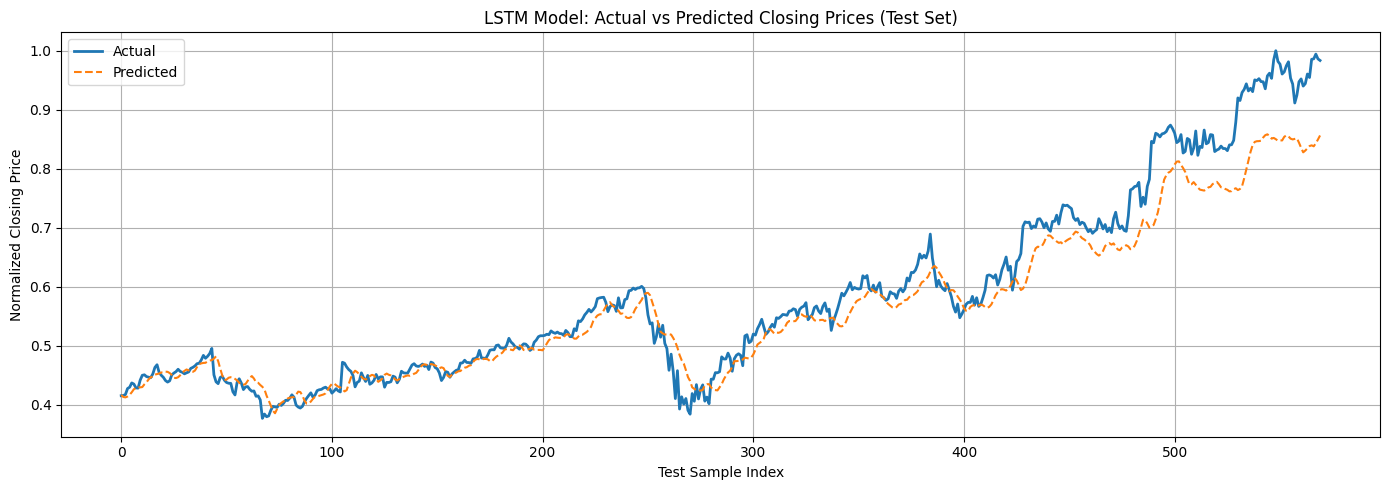

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(y_test, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.title("LSTM Model: Actual vs Predicted Closing Prices (Test Set)")
plt.xlabel("Test Sample Index")
plt.ylabel("Normalized Closing Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Conclusion

The LSTM model was trained using a 5-day input window and a rich set of engineered features, including trend, volatility, and momentum indicators. The model achieved a low Mean Absolute Error (MAE) of approximately 2.97, along with competitive RMSE and SMAPE values. This performance is a significant improvement compared to the benchmark study, where the LSTM model yielded a much higher MAE using similar data. The visual plot of predicted versus actual prices further supports the model’s ability to capture the underlying trends in stock movement, even though some lag is visible during sharp fluctuations. Overall, the results show that incorporating technical indicators and time-based features helped improve the model’s forecasting ability, making the LSTM implementation both effective and reliable for daily stock price prediction.
